# Phase 1 - Binary classifier to predict in-hospital mortality

We propose to a two-phase model framework to predict in-hospital mortality and death time in hours. This notebook presents the machine learning pipeline for model training, hyperparameter tuning and model evaluation in Phase 1. In Phase 1, a binary classifier was trained to predict in-hospital mortality using the 123 features extracted from the previous stage of feature engineering in Hive. 

* Part 1. Define classes and methods for the machine learning pipieline
* Part 2. Model training and evaluation using 6-hour, 12-hour, 24-hour data
* Part 3. Visualization of ROC curves
* Part 4: Visualization of feature importance

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, Imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import *
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---
## Part 1. Define classes and methods for the machine learning pipieline

First, we define the classes of `CustomLabelBinarizer`, `ItemSelector` and `MultiItemSelector` for custom data transformation in sklearn pipieline. Specifically, 
* `CustomLabelBinarizer` converts multi-class labels to binary labels.
* `ItemSelector` and `MultiItemSelector` select custom features from the input dataframe.

In [24]:
unseen_label = "__New__"
seed = 200

class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.le = LabelEncoder()
        self.lb = LabelBinarizer()
        self.seen_labels = set()
        
    def fit(self, x, y=None,**fit_params):
        self.seen_labels = set(x)
        self.seen_labels.add(unseen_label)
        
        # add "unseen" to X
        x_new = list(x)
        x_new.append(unseen_label)

        label_encoded = self.le.fit_transform(x_new)
        self.lb.fit(label_encoded)
        return self
    
    def transform(self, x):
        x_new = list(map(lambda label: label if label in self.seen_labels else unseen_label, list(x)))
        label_encoded = self.le.transform(x_new)
        return self.lb.transform(label_encoded)
    
    
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key]

    
class MultiItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key_list):
        self.key_list = key_list

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key_list]

Next, we define a useful methods `evaluate()` for model evaluation. It would evaluates the model performance and prints a detailed report of the performance metrics e.g. accuracy, AUC score, precision, recall and F1 score.

In [25]:
def evaluate(y_true, y_pred, y_pred_proba):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred)   
    print ("Accuracy : {:.4f}".format(acc))
    print("AUC score : {:.4f}".format(auc))
    print("Precision : {:.4f}".format(precision))
    print("Recall : {:.4f}".format(recall))
    print("F1 score : {:.4f}".format(f1score))
    print("\nClassification report : \n", classification_report(y_true, y_pred))
    print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))
    return acc, auc, precision, recall, f1score

Now, we are ready to define the main method `train_evaluate_model`. The method does the following:

* Split data into 80% training set and 20% test set
* Build custom machine learning pipeline which 
    * select specified features from the input dataframe (`ItemSelector` and `MultiItemSelector`) 
    * transform categorical data into binary label (`CustomLabelBinarizer`) 
    * impute missing values for numerical data with median (`Imputer`)
    * train `RandomForestClassifier` using `GridSearchCV` on 5-fold CV of the training set
    * find the best parameter set from the grid search
* Evaluate the model performance using the best parameter set on the test set

Note that `hospital_expire_flag=1` indicates in-hospital mortality. We will train the classifier to predict this mortality label. Also note that we have selected 123 extracted features covering 3 categorial variables and 120 numerical variables. 

In [36]:
def train_evaluate_model(df):
    
    # split data into 80% training set, 20% test set
    train_cv_df = df.sample(frac=0.8, random_state=seed)
    test_df = df.drop(train_cv_df.index)
    print(df.shape, train_cv_df.shape, test_df.shape)

    # define the machine learning pipeline
    discrete_pipeline = Pipeline([
        ("feature_union", FeatureUnion(
            transformer_list=[
                # categorical pipeline
                ('ethnicity', Pipeline([
                    ("selector", ItemSelector(key='ethnicity')),
                    ("binarizer", CustomLabelBinarizer())
                ])),            
                ("gender", Pipeline([
                    ("selector", ItemSelector(key='gender')),
                    ("binarizer", CustomLabelBinarizer())
                ])),
                ("admission_type", Pipeline([
                    ("selector", ItemSelector(key='admission_type')),
                    ("binarizer", CustomLabelBinarizer())
                ])),

                # numerical pipeline
                ("numerical", Pipeline([
                    ("selector", MultiItemSelector(key_list=
                          ['age', 'icustay_num',
                           'heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
                           'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean', 
                           'heartrate_min', 'sysbp_min', 'diasbp_min','meanbp_min', 
                           'resprate_min', 'tempc_min', 'spo2_min', 'glucose_min',
                           'heartrate_max', 'sysbp_max', 'diasbp_max', 'meanbp_max',
                           'resprate_max', 'tempc_max', 'spo2_max', 'glucose_max', 
                           'gcs_mean', 'gcsmotor_mean', 'gcsverbal_mean', 'gcseyes_mean', 'endotrachflag_mean',
                           'gcs_min', 'gcsmotor_min', 'gcsverbal_min', 'gcseyes_min', 'endotrachflag_min', 
                           'gcs_max', 'gcsmotor_max', 'gcsverbal_max', 'gcseyes_max', 'endotrachflag_max', 
                           'baseexcess_mean', 'carboxyhemoglobin_mean', 'methemoglobin_mean', 
                           'po2_mean', 'pco2_mean', 'ph_mean', 'pao2fio2ratio_mean', 'totalco2_mean', 
                           'aniongap_mean', 'albumin_mean', 'bands_mean', 'bicarbonate_mean', 
                           'bilirubin_mean', 'calcium_mean', 'creatinine_mean', 'chloride_mean', 
                           'hematocrit_mean', 'hemoglobin_mean', 'lactate_mean', 'platelet_mean', 
                           'potassium_mean', 'ptt_mean', 'inr_mean', 'sodium_mean', 'bun_mean', 'wbc_mean',
                           'baseexcess_min', 'carboxyhemoglobin_min', 'methemoglobin_min',
                           'po2_min', 'pco2_min', 'ph_min', 'pao2fio2ratio_min', 'totalco2_min',
                           'aniongap_min', 'albumin_min', 'bands_min', 'bicarbonate_min',
                           'bilirubin_min', 'calcium_min', 'creatinine_min', 'chloride_min',
                           'hematocrit_min', 'hemoglobin_min', 'lactate_min', 'platelet_min',
                           'potassium_min', 'ptt_min', 'inr_min', 'sodium_min', 'bun_min', 'wbc_min', 
                           'baseexcess_max', 'carboxyhemoglobin_max', 'methemoglobin_max', 
                           'po2_max', 'pco2_max', 'ph_max', 'pao2fio2ratio_max', 'totalco2_max',          
                           'aniongap_max', 'albumin_max', 'bands_max', 'bicarbonate_max', 
                           'bilirubin_max', 'calcium_max', 'creatinine_max', 'chloride_max', 
                           'hematocrit_max', 'hemoglobin_max', 'lactate_max', 'platelet_max', 
                           'potassium_max', 'ptt_max', 'inr_max', 'sodium_max', 'bun_max', 'wbc_max', 
                           'urineoutput'])),
                    # impute missing values with median
                    ("imputer", Imputer(strategy="median",
                                              axis=0)),
                ]))
            ]
        )),

        ("algorithm", RandomForestClassifier(n_jobs=-1))
    ])
    
    # define the parameter grid
    parameters = {'algorithm__n_estimators': [100, 250, 500],
                  'algorithm__max_features': ["auto", "sqrt", "log2"],
                  "algorithm__criterion": ["gini", "entropy"],
                  "algorithm__max_depth": [5, 10, 30],
                  "algorithm__bootstrap": [True, False]}
    
    # grid search on 5-fold CV, trained on 80% training set
    grid_search = GridSearchCV(discrete_pipeline, parameters, n_jobs=-1, verbose=0, refit=True, cv=5, scoring='roc_auc')
    grid_search.fit(train_cv_df, train_cv_df.hospital_expire_flag)

    # retrieve the best parameter set from grid search
    print("\nGrid Search Best parameters set :")
    print(grid_search.best_params_)
    print("\nBest score: %0.3f" % grid_search.best_score_)
    
    # print test score on each fit
#     print("\nGrid scores :")
#     means = grid_search.cv_results_['mean_test_score']
#     stds = grid_search.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

    # evaluate model performance on test set
    print("\nEvaluation on Test Set (20%) :")
    test_actual = test_df.hospital_expire_flag
    test_pred = grid_search.predict(test_df)
    test_pred_proba = grid_search.predict_proba(test_df)[:,1]
    evaluate(test_actual, test_pred, test_pred_proba)

    return grid_search, test_actual, test_pred_proba

---
## Part 2. Model training and evaluation using 6-hour, 12-hour, 24-hour data
Now we have defined our custom machine learning pipeline, we are ready to fit the 6-hour, 12-hour and 24-hour data to the pipeline respectively.

In [37]:
# load 6-hour, 12-hour and 24-hour data extracted previously using Hive
df_6hr = pd.read_csv('../data/mp_data_6hr.csv')
df_12hr = pd.read_csv('../data/mp_data_12hr.csv')
df_24hr = pd.read_csv('../data/mp_data_24hr.csv')

print(df_6hr.shape, df_12hr.shape, df_24hr.shape)
df_6hr.head()

(49632, 131) (49632, 131) (49632, 131)


,subject_id,hadm_id,icustay_id,dbsource,expire_flag,hospital_expire_flag,deathtime_hours,hosp_deathtime_hours,age,gender,...,hemoglobin_max,lactate_max,platelet_max,potassium_max,ptt_max,inr_max,sodium_max,bun_max,wbc_max,urineoutput
0,3,145834,211552,carevue,1,0,5669.0,NaN,76.5246,M,...,10.1,8.0,221.5,4.05,52.35,1.7,141.5,42.0,15.2,20.0
1,4,185777,294638,carevue,0,0,NaN,NaN,47.8450,F,...,10.6,NaN,201.0,3.30,33.20,1.1,141.0,10.0,9.7,550.0
2,6,107064,228232,carevue,0,0,NaN,NaN,65.9398,F,...,9.2,NaN,330.0,4.80,41.20,1.1,134.0,65.0,10.6,760.0
3,9,150750,220597,carevue,1,1,107.0,118.0,41.7887,M,...,14.0,1.9,NaN,2.90,NaN,NaN,138.0,NaN,NaN,1450.0
4,11,194540,229441,carevue,1,0,5082.0,NaN,50.1476,F,...,12.6,NaN,258.0,3.90,NaN,NaN,141.0,14.0,9.3,400.0


In [38]:
grid_search = {}
test_actual = {}
test_pred_proba = {}

# fit the pipeline and evaluate the model using 6-hour data
grid_search[0], test_actual[0], test_pred_proba[0] = train_evaluate_model(df_6hr)

(49632, 131) (39706, 131) (9926, 131)

Grid Search Best parameters set :
{'algorithm__bootstrap': False, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 30, 'algorithm__max_features': 'log2', 'algorithm__n_estimators': 500}

Best score: 0.883

Evaluation on Test Set (20%) :
Accuracy : 0.9053
AUC score : 0.8817
Precision : 0.8350
Recall : 0.2249
F1 score : 0.3544

Classification report : 
              precision    recall  f1-score   support

          0       0.91      0.99      0.95      8779
          1       0.83      0.22      0.35      1147

avg / total       0.90      0.91      0.88      9926


Confusion matrix : 
 [[8728   51]
 [ 889  258]]


In [39]:
# fit the pipeline and evaluate the model using 12-hour data
grid_search[1], test_actual[1], test_pred_proba[1] = train_evaluate_model(df_12hr)

(49632, 131) (39706, 131) (9926, 131)

Grid Search Best parameters set :
{'algorithm__bootstrap': False, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 30, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 500}

Best score: 0.902

Evaluation on Test Set (20%) :
Accuracy : 0.9136
AUC score : 0.9033
Precision : 0.8533
Recall : 0.3043
F1 score : 0.4486

Classification report : 
              precision    recall  f1-score   support

          0       0.92      0.99      0.95      8779
          1       0.85      0.30      0.45      1147

avg / total       0.91      0.91      0.89      9926


Confusion matrix : 
 [[8719   60]
 [ 798  349]]


In [40]:
# fit the pipeline and evaluate the model using 24-hour data
grid_search[2], test_actual[2], test_pred_proba[2] = train_evaluate_model(df_24hr)

(49632, 131) (39706, 131) (9926, 131)

Grid Search Best parameters set :
{'algorithm__bootstrap': False, 'algorithm__criterion': 'entropy', 'algorithm__max_depth': 30, 'algorithm__max_features': 'auto', 'algorithm__n_estimators': 500}

Best score: 0.920

Evaluation on Test Set (20%) :
Accuracy : 0.9189
AUC score : 0.9194
Precision : 0.8353
Recall : 0.3714
F1 score : 0.5142

Classification report : 
              precision    recall  f1-score   support

          0       0.92      0.99      0.96      8779
          1       0.84      0.37      0.51      1147

avg / total       0.91      0.92      0.90      9926


Confusion matrix : 
 [[8695   84]
 [ 721  426]]


---
## Part 3. Visualization of ROC curves

Just now, we have trained random forest classifiers using 6-hour, 12-hour and 24-hour data respectively. We can now compare and visualize their ROC curves on the test set.

In [41]:
fpr = {}  #false positive rate
tpr = {}  #true positive rate
roc_auc = {}  #auc score

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(test_actual[i], test_pred_proba[i])
    roc_auc[i] = roc_auc_score(test_actual[i], test_pred_proba[i])

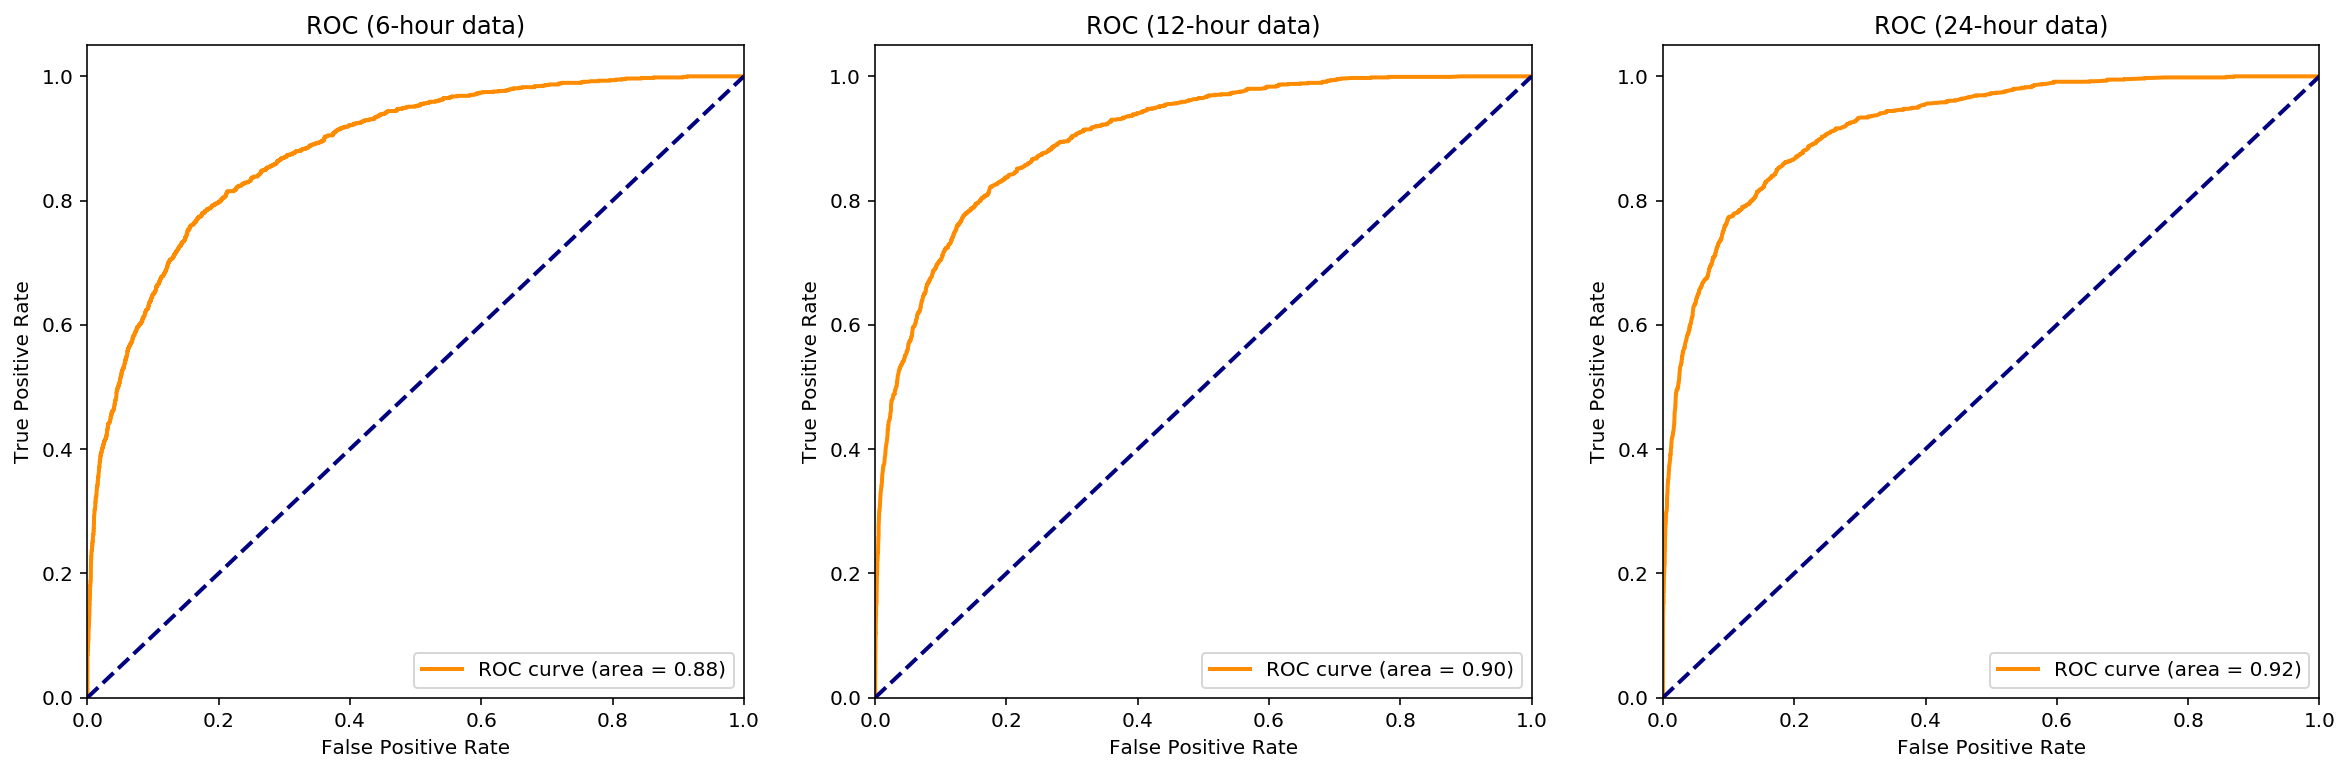

In [42]:
fig = plt.figure()
fig.set_size_inches(20,6)

plt.subplot(1,3,1)
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (6-hour data)')
plt.legend(loc="lower right")

plt.subplot(1,3,2)
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (12-hour data)')
plt.legend(loc="lower right")

plt.subplot(1,3,3)
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (24-hour data)')
plt.legend(loc="lower right")

fig.savefig('../img/figure2.png')
plt.show()

---
## Part 4. Visualization of Feature Importance

* In this part, we want to dive deeper to visualize the feature importance of the random forest classifier trained on 6-hour ICU data. Let's us first retrain the classifier with the best parameter set resulted from the grid search in Part 2, so that we can retreive the feature importance.

In [45]:
# show best parameter resulted from grid search
grid_search[0].best_params_

{'algorithm__bootstrap': False,
 'algorithm__criterion': 'entropy',
 'algorithm__max_depth': 30,
 'algorithm__max_features': 'log2',
 'algorithm__n_estimators': 500}

In [84]:
# load data
df_6hr = pd.read_csv('../data/mp_data_6hr.csv')

# define features
categorical_features = ['gender', 'ethnicity', 'admission_type']
numerical_features = ['age', 'icustay_num',
                       'heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
                       'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean', 
                       'heartrate_min', 'sysbp_min', 'diasbp_min','meanbp_min', 
                       'resprate_min', 'tempc_min', 'spo2_min', 'glucose_min',
                       'heartrate_max', 'sysbp_max', 'diasbp_max', 'meanbp_max',
                       'resprate_max', 'tempc_max', 'spo2_max', 'glucose_max', 
                       'gcs_mean', 'gcsmotor_mean', 'gcsverbal_mean', 'gcseyes_mean', 'endotrachflag_mean',
                       'gcs_min', 'gcsmotor_min', 'gcsverbal_min', 'gcseyes_min', 'endotrachflag_min', 
                       'gcs_max', 'gcsmotor_max', 'gcsverbal_max', 'gcseyes_max', 'endotrachflag_max', 
                       'baseexcess_mean', 'carboxyhemoglobin_mean', 'methemoglobin_mean', 
                       'po2_mean', 'pco2_mean', 'ph_mean', 'pao2fio2ratio_mean', 'totalco2_mean', 
                       'aniongap_mean', 'albumin_mean', 'bands_mean', 'bicarbonate_mean', 
                       'bilirubin_mean', 'calcium_mean', 'creatinine_mean', 'chloride_mean', 
                       'hematocrit_mean', 'hemoglobin_mean', 'lactate_mean', 'platelet_mean', 
                       'potassium_mean', 'ptt_mean', 'inr_mean', 'sodium_mean', 'bun_mean', 'wbc_mean',
                       'baseexcess_min', 'carboxyhemoglobin_min', 'methemoglobin_min',
                       'po2_min', 'pco2_min', 'ph_min', 'pao2fio2ratio_min', 'totalco2_min',
                       'aniongap_min', 'albumin_min', 'bands_min', 'bicarbonate_min',
                       'bilirubin_min', 'calcium_min', 'creatinine_min', 'chloride_min',
                       'hematocrit_min', 'hemoglobin_min', 'lactate_min', 'platelet_min',
                       'potassium_min', 'ptt_min', 'inr_min', 'sodium_min', 'bun_min', 'wbc_min', 
                       'baseexcess_max', 'carboxyhemoglobin_max', 'methemoglobin_max', 
                       'po2_max', 'pco2_max', 'ph_max', 'pao2fio2ratio_max', 'totalco2_max',          
                       'aniongap_max', 'albumin_max', 'bands_max', 'bicarbonate_max', 
                       'bilirubin_max', 'calcium_max', 'creatinine_max', 'chloride_max', 
                       'hematocrit_max', 'hemoglobin_max', 'lactate_max', 'platelet_max', 
                       'potassium_max', 'ptt_max', 'inr_max', 'sodium_max', 'bun_max', 'wbc_max', 
                       'urineoutput']
features = categorical_features + numerical_features 

# impute missing values of numerical features with median
for col in numerical_features:
    df_6hr[col].fillna(df_6hr[col].median(), inplace=True)
    
# encoding categorical features
le_gender = LabelEncoder()
df_6hr['gender'] = le_gender.fit_transform(df_6hr.gender)
le_enthnicity = LabelEncoder()
df_6hr['ethnicity'] = le_enthnicity.fit_transform(df_6hr.ethnicity)
le_admission_type = LabelEncoder()
df_6hr['admission_type'] = le_admission_type.fit_transform(df_6hr.admission_type)

# train-test split
y = df_6hr.hospital_expire_flag
X = df_6hr[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# train classifier with the best paramter set
best_params = grid_search[0].best_params_
clf = RandomForestClassifier(n_estimators=best_params['algorithm__n_estimators'], 
                            max_features=best_params['algorithm__max_features'],
                            max_depth=best_params['algorithm__max_depth'],
                            bootstrap=best_params['algorithm__bootstrap'],
                            criterion=best_params['algorithm__criterion'],
                            random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)
print("Accuracy score on training set and test set: ", clf.score(X_train, y_train), clf.score(X_test, y_test))

Accuracy score on training set and test set:  0.9999496285102631 0.9074241966354387


Top 10 features
age               0.022921
resprate_mean     0.021494
urineoutput       0.020296
resprate_min      0.016600
sysbp_mean        0.016380
tempc_mean        0.015201
bun_max           0.014993
sysbp_min         0.014915
resprate_max      0.014762
heartrate_mean    0.014715
dtype: float64


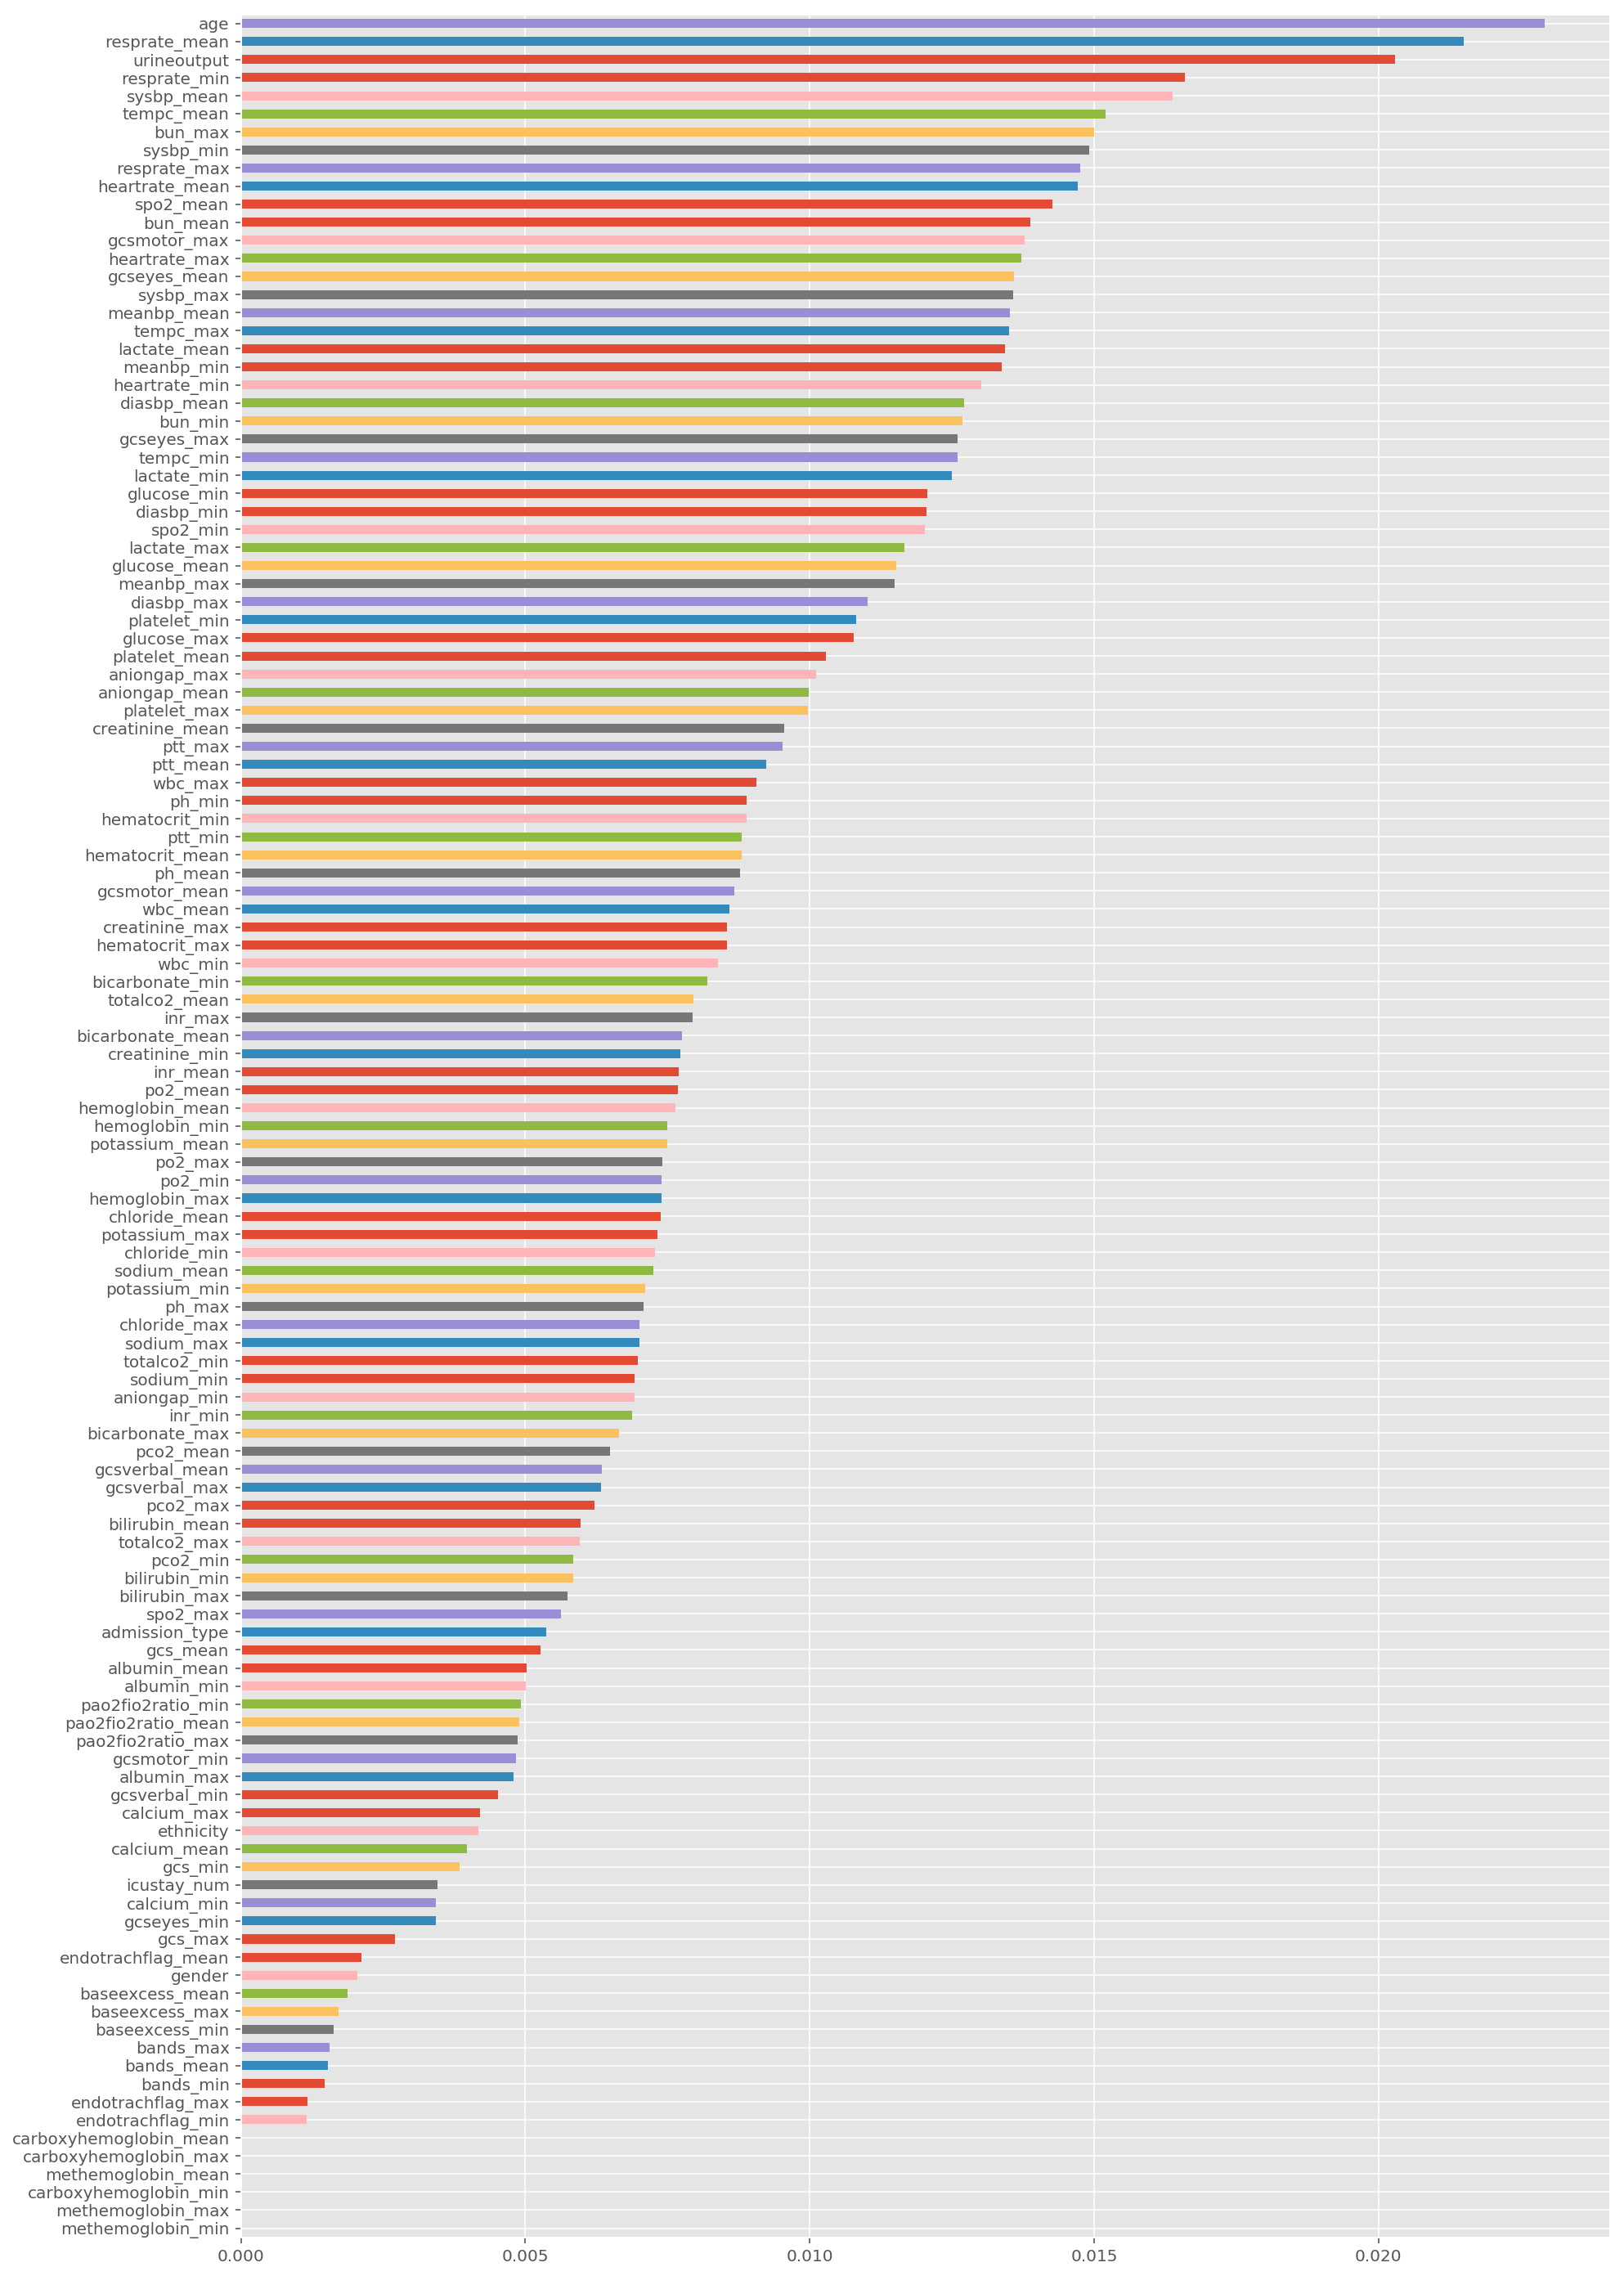

In [88]:
# plot feature importance
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(15,25)
    
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
print("Top 10 features")
print(feat_importances.nlargest(10))

feat_importances.nsmallest(123).plot(kind='barh')

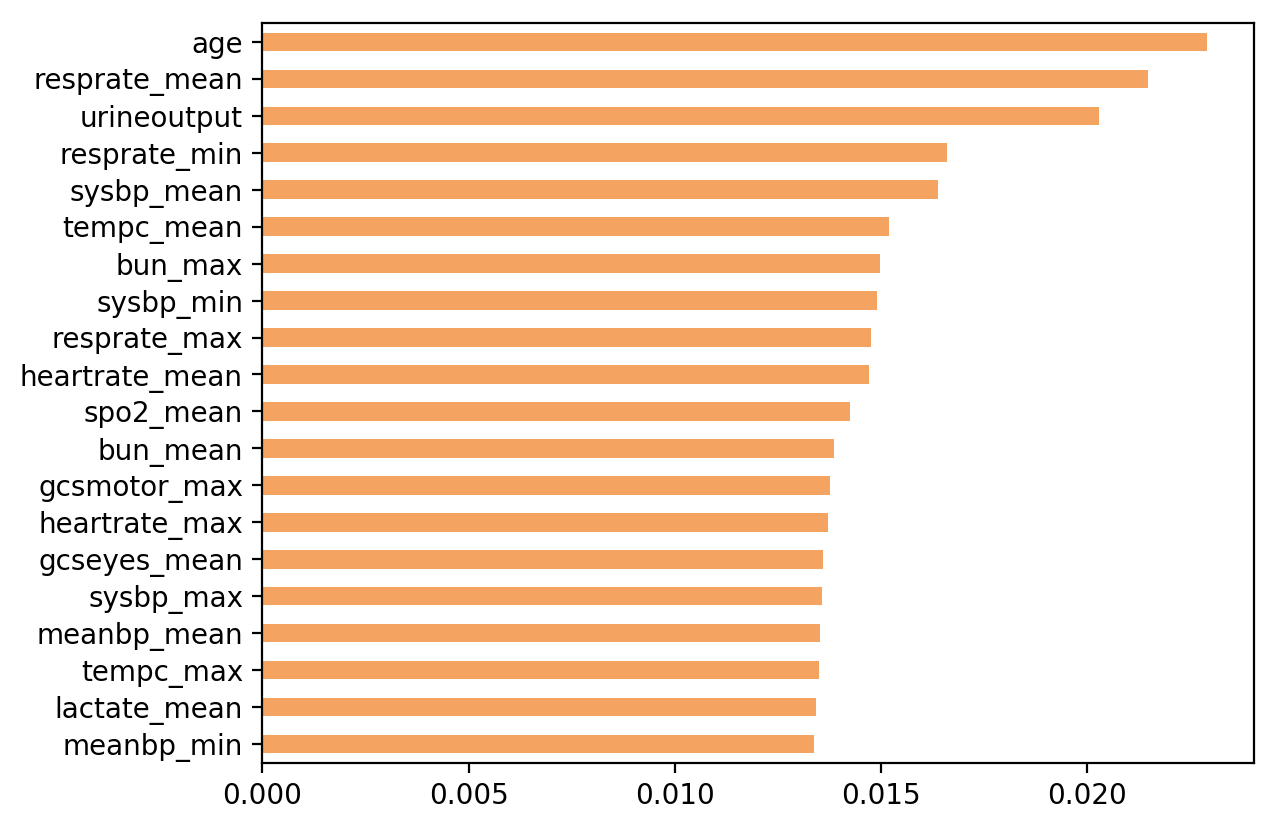

In [139]:
# plot top 20 feature importance
plt.style.use('default')
fig.set_size_inches(15,10)
fig = plt.figure()
feat_importances.nlargest(20).sort_values(ascending=True).plot(kind='barh', color='sandybrown')
fig.savefig('../img/figure6.png', bbox_inches='tight', pad_inches=0.5)
plt.show()